In [62]:
import numpy as np

import data_io
import metrics
import validation
import implementations
import data_preprocessing

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 250
import seaborn as sns
sns.set(style='whitegrid')

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
def get_predictor(w):
    def foo(features):
        return (features @ w > 0).astype(int)
    return foo

In [136]:
import operator

def tune_lambda(y, x, grid, seed=42):
    w_init = np.zeros(tx.shape[1])
    res = {}
    for lambda_ in grid:
        np.random.seed(seed)
        train_model = lambda y_, x_: get_predictor(implementations.reg_logistic_regression_sgd(
            y_, x_, lambda_, w_init, 5, 1000, 0.5,
        )[0])
        res[lambda_] = validation.cross_validation(y, x, train_model, 5)[0].mean()
        print(f"{lambda_}: {res[lambda_]:.4f}")
    return max(res.items(), key=operator.itemgetter(1))[0]

### Data

In [65]:
DATA_FILE_PREFIX = 'data/'
y, x, ids, cols = data_io.load_csv_data(f'{DATA_FILE_PREFIX}train.csv')
y = (y + 1) // 2

# Make it easier to access columns by their name
col_to_index_mapping = {col_name: index - 2 for index, col_name in enumerate(cols) if index >= 2}

###### baseline

In [80]:
def transformation_pipeline_base(x, col_to_index_mapping=col_to_index_mapping):
    tx = np.copy(x) # Recommended to copy x so it doesn't change
    tx[tx == -999.] = np.nan
    tx = data_preprocessing.apply_transformation(
        tx,
        [col_to_index_mapping[key] for key in col_to_index_mapping if 'PRI_jet_num' not in key],
        data_preprocessing.standardize_with_nans,
    )
    # standardize and normalize may change value of fields from default missing values, so it uses matrix calculated before applying transformations
    tx = data_preprocessing.nullify_missing_values(tx, np.isnan(tx)) 
    # onehot for categorical and drop one level
    tx, col_to_index_mapping_upd = data_preprocessing.one_hot_transformation(tx, 'PRI_jet_num', col_to_index_mapping)
    tx = tx[:, :-1]
    # add bias
    tx = data_preprocessing.prepend_bias_column(tx)
    return tx

In [81]:
tx = transformation_pipeline_base(x)
tx.shape, y.shape

((250000, 33), (250000,))

In [82]:
# cross validation score
np.random.seed(42)

w_init = np.zeros(tx.shape[1])
lambda_ = 1e-5
train_model = lambda y, x: get_predictor(implementations.reg_logistic_regression_sgd(
    y, x, lambda_, w_init, 5, 1000, 0.5,
)[0])

res = validation.cross_validation(y, tx, train_model, 5, verbose=True)

------ 5-fold cross validation results ------
    Accuracy: avg 0.75182, max 0.7547, min 0.74844, stddev 0.0024897
    Fbeta score: avg 0.595, max 0.60451, min 0.58853, stddev 0.005581


In [83]:
# find the best lambda
best_lambda = tune_lambda(y, tx, np.concatenate([[0], np.logspace(-6, 0, 7)]))

0.0: 0.7518
1e-06: 0.7518
1e-05: 0.7518
0.0001: 0.7518
0.001: 0.7508
0.01: 0.7439
0.1: 0.7260
1.0: 0.7036


In [84]:
best_lambda

0.0

In [85]:
# check convergence
np.random.seed(42)

w = np.random.randn(tx.shape[1]) * 0
w, hist = implementations.reg_logistic_regression_sgd(y, tx, best_lambda, w, 5, 1000, 0.5, history=True)

(0.45, 0.7)

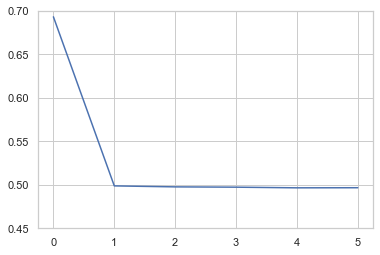

In [86]:
plt.plot(hist)
plt.ylim(0.45, 0.7)

##### NA values: replace with median

In [87]:
def transformation_pipeline_median(x, col_to_index_mapping=col_to_index_mapping):
    tx = np.copy(x) # Recommended to copy x so it doesn't change
    tx[tx == -999.] = np.nan
    tx = data_preprocessing.apply_transformation(
        tx,
        [col_to_index_mapping[key] for key in col_to_index_mapping if 'PRI_jet_num' not in key],
        data_preprocessing.standardize_with_nans,
    )
    # standardize and normalize may change value of fields from default missing values, so it uses matrix calculated before applying transformations
    tx = data_preprocessing.median_missing_values(tx, np.isnan(tx)) 
    # onehot for categorical and drop one level
    tx, col_to_index_mapping_upd = data_preprocessing.one_hot_transformation(tx, 'PRI_jet_num', col_to_index_mapping)
    tx = tx[:, :-1]
    # add bias
    tx = data_preprocessing.prepend_bias_column(tx)
    return tx

In [88]:
tx = transformation_pipeline_median(x)

In [89]:
np.random.seed(42)

w_init = np.zeros(tx.shape[1])
lambda_ = 1e-5
train_model = lambda y, x: get_predictor(implementations.reg_logistic_regression_sgd(
    y, x, lambda_, w_init, 5, 1000, 0.5,
)[0])

res = validation.cross_validation(y, tx, train_model, 5, verbose=True)

------ 5-fold cross validation results ------
    Accuracy: avg 0.75216, max 0.75514, min 0.74856, stddev 0.0025507
    Fbeta score: avg 0.5955, max 0.60422, min 0.58998, stddev 0.0050626


In [20]:
best_lambda = tune_lambda(y, tx, np.concatenate([[0], np.logspace(-6, 0, 7)]))

0.0: 0.7521
1e-06: 0.7521
1e-05: 0.7521
0.0001: 0.7520
0.001: 0.7511
0.01: 0.7435
0.1: 0.7246
1.0: 0.7029


In [21]:
best_lambda

0.0

##### add new columns + nullify

In [113]:
def transformation_pipeline_onehot(x, col_to_index_mapping=col_to_index_mapping, test=False):
    tx = np.copy(x) # Recommended to copy x so it doesn't change
    tx[tx == -999.] = np.nan
    tx = data_preprocessing.apply_transformation(
        tx,
        [col_to_index_mapping[key] for key in col_to_index_mapping if 'PRI_jet_num' not in key],
        data_preprocessing.standardize_with_nans,
    )
    # standardize and normalize may change value of fields from default missing values, so it uses matrix calculated before applying transformations
    # onehot for categorical and drop one level
    tx, col_to_index_mapping_upd = data_preprocessing.one_hot_transformation(tx, 'PRI_jet_num', col_to_index_mapping)
    tx, col_to_index_mapping_upd = data_preprocessing.onehot_missing_values(tx, np.isnan(tx), col_to_index_mapping_upd)
    tx = data_preprocessing.nullify_missing_values(tx, np.isnan(tx))    
    tx = tx[:, :-1]
    # add bias
    tx = data_preprocessing.prepend_bias_column(tx)
    return tx, col_to_index_mapping_upd

In [114]:
tx, col_to_index_mapping_upd = transformation_pipeline_onehot(x)

In [115]:
np.random.seed(42)

w_init = np.zeros(tx.shape[1])
lambda_ = 1e-5
train_model = lambda y, x: get_predictor(implementations.reg_logistic_regression_sgd(
    y, x, lambda_, w_init, 5, 1000, 0.5,
)[0])

res = validation.cross_validation(y, tx, train_model, 5, verbose=True)

------ 5-fold cross validation results ------
    Accuracy: avg 0.75182, max 0.75476, min 0.74912, stddev 0.0019348
    Fbeta score: avg 0.59238, max 0.59718, min 0.5804, stddev 0.0061037


In [116]:
best_lambda = tune_lambda(y, tx, np.concatenate([[0], np.logspace(-6, 0, 7)]))

0.0: 0.7518
1e-06: 0.7519
1e-05: 0.7519
0.0001: 0.7519
0.001: 0.7508
0.01: 0.7433
0.1: 0.7158
1.0: 0.6767


In [117]:
best_lambda

1e-06

### Degree 2
##### nans: null

In [171]:
def transformation_pipeline_degree_2(x, col_to_index_mapping=col_to_index_mapping):
    tx = np.copy(x) # Recommended to copy x so it doesn't change
    tx[tx == -999.] = np.nan
    tx = data_preprocessing.apply_transformation(
        tx,
        [col_to_index_mapping[key] for key in col_to_index_mapping if 'PRI_jet_num' not in key],
        data_preprocessing.standardize_with_nans,
    )
    # standardize and normalize may change value of fields from default missing values, so it uses matrix calculated before applying transformations
    tx = data_preprocessing.nullify_missing_values(tx, np.isnan(tx))    
    # onehot for categorical and drop one level
    tx, col_to_index_mapping_upd = data_preprocessing.one_hot_transformation(tx, 'PRI_jet_num', col_to_index_mapping)
    tx = tx[:, :-1]
    # add squared features
    tx = data_preprocessing.build_poly(
        tx, 
        [col_to_index_mapping_upd[key] for key in col_to_index_mapping_upd if 'PRI_jet_num' not in key],
        2
    )
    # add bias
    tx = data_preprocessing.prepend_bias_column(tx)
    return tx

In [172]:
tx = transformation_pipeline_degree_2(x)

In [173]:
np.random.seed(42)

w_init = np.zeros(tx.shape[1])
lambda_ = 1e-5
train_model = lambda y, x: get_predictor(implementations.reg_logistic_regression_sgd(
    y, x, lambda_, w_init, 20, 1000, 0.01,
)[0])

res = validation.cross_validation(y, tx, train_model, 5, verbose=True)

------ 5-fold cross validation results ------
    Accuracy: avg 0.79968, max 0.80314, min 0.79532, stddev 0.0025036
    Fbeta score: avg 0.68527, max 0.69139, min 0.6782, stddev 0.004564


In [174]:
def tune_lambda(y, x, grid, seed=42):
    w_init = np.zeros(tx.shape[1])
    res = {}
    for lambda_ in grid:
        np.random.seed(seed)
        train_model = lambda y_, x_: get_predictor(implementations.reg_logistic_regression_sgd(
            y_, x_, lambda_, w_init, 20, 1000, 0.01,
        )[0])
        res[lambda_] = validation.cross_validation(y, x, train_model, 5)[0].mean()
        print(f"{lambda_}: {res[lambda_]:.4f}")
    return max(res.items(), key=operator.itemgetter(1))[0]

best_lambda = tune_lambda(y, tx, np.concatenate([[0], np.logspace(-6, 0, 7)]))

0.0: 0.7997
1e-06: 0.8018
1e-05: 0.8021
0.0001: 0.8023
0.001: 0.8021
0.01: 0.7962
0.1: 0.7712
1.0: 0.7126


In [175]:
best_lambda

0.0001

##### submit

In [176]:
w_init = np.zeros(tx.shape[1])
lambda_ = 0.0001
train_model = lambda y, x: get_predictor(implementations.reg_logistic_regression_sgd(
    y, x, lambda_, w_init, 20, 1000, 0.1,
)[0])

model = train_model(y, tx)

In [177]:
w, hist = implementations.reg_logistic_regression_sgd(
    y, tx, lambda_, w_init, 20, 1000, 0.1, history=True,
)

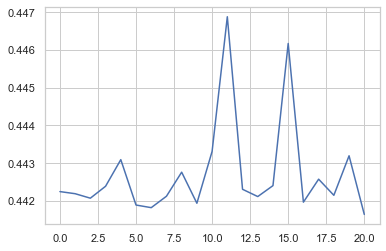

In [178]:
plt.plot(hist)

In [179]:
pred = model(tx)
metrics.accuracy(y, pred)

0.801908

In [180]:
#DATA_FILE_PREFIX = './/data/'
DATA_FILE_PREFIX = 'data/'
y_test, x_test, ids_test, cols = data_io.load_csv_data(f'{DATA_FILE_PREFIX}test.csv')
y_test = (y_test + 1) // 2

In [181]:
tx_test = transformation_pipeline_degree_2(x_test)

In [182]:
predictions = model(tx_test)

In [183]:
y_test = predictions * 2 - 1

In [184]:
data_io.create_csv_submission(ids_test, y_test, 'data/degree2.csv')

### Degree 2 + pairwise

In [203]:
def transformation_pipeline_pairwise(x, col_to_index_mapping=col_to_index_mapping):
    tx = np.copy(x) # Recommended to copy x so it doesn't change
    tx[tx == -999.] = np.nan
    tx = data_preprocessing.apply_transformation(
        tx,
        [col_to_index_mapping[key] for key in col_to_index_mapping if 'PRI_jet_num' not in key],
        data_preprocessing.standardize_with_nans,
    )
    # standardize and normalize may change value of fields from default missing values, so it uses matrix calculated before applying transformations
    tx = data_preprocessing.median_missing_values(tx, np.isnan(tx))    
    # onehot for categorical and drop one level
    tx, col_to_index_mapping_upd = data_preprocessing.one_hot_transformation(tx, 'PRI_jet_num', col_to_index_mapping)
    tx = tx[:, :-1]
    # add squared features
    tx = data_preprocessing.build_poly(
        tx, 
        [col_to_index_mapping[key] for key in col_to_index_mapping if 'PRI_jet_num' not in key],
        2
    )
    # add pairwise multiplied features
    tx = data_preprocessing.build_pairwise(
        tx, 
        [col_to_index_mapping[key] for key in col_to_index_mapping]
    )
    # add bias
    tx = data_preprocessing.prepend_bias_column(tx)
    return tx

In [204]:
tx = transformation_pipeline_pairwise(x)

In [205]:
np.random.seed(42)

w_init = np.zeros(tx.shape[1])
lambda_ = 1e-5
train_model = lambda y, x: get_predictor(implementations.reg_logistic_regression_sgd(
    y, x, lambda_, w_init, 20, 1000, 0.01,
)[0])

res = validation.cross_validation(y, tx, train_model, 5, verbose=True)

------ 5-fold cross validation results ------
    Accuracy: avg 0.81934, max 0.8214, min 0.8161, stddev 0.0019999
    Fbeta score: avg 0.7245, max 0.73005, min 0.71722, stddev 0.0048735


In [206]:
best_lambda = tune_lambda(y, tx, np.concatenate([[0], np.logspace(-6, -2, 5)]))

0.0: 0.8193
1e-06: 0.8203
1e-05: 0.8217
0.0001: 0.8219
0.001: 0.8220
0.01: 0.8175


In [192]:
best_lambda = tune_lambda(y, tx, np.concatenate([[0], np.logspace(-6, -1, 6)]))

0.0: 0.8189
1e-06: 0.8215
1e-05: 0.8207
0.0001: 0.8214
0.001: 0.8216
0.01: 0.8175
0.1: 0.7959


In [207]:
best_lambda

0.001

##### submit

In [208]:
w_init = np.zeros(tx.shape[1])
lambda_ = 0.001
train_model = lambda y, x: get_predictor(implementations.reg_logistic_regression_sgd(
    y, x, lambda_, w_init, 20, 1000, 0.1,
)[0])

model = train_model(y, tx)

In [209]:
w, hist = implementations.reg_logistic_regression_sgd(
    y, tx, lambda_, w_init, 20, 1000, 0.1, history=True,
)

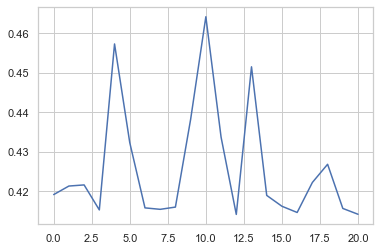

In [210]:
plt.plot(hist)

In [211]:
pred = model(tx)
metrics.accuracy(y, pred)

0.821088

In [212]:
#DATA_FILE_PREFIX = './/data/'
DATA_FILE_PREFIX = 'data/'
y_test, x_test, ids_test, cols = data_io.load_csv_data(f'{DATA_FILE_PREFIX}test.csv')
y_test = (y_test + 1) // 2

In [213]:
tx_test = transformation_pipeline_pairwise(x_test)

In [214]:
predictions = model(tx_test)

In [215]:
y_test = predictions * 2 - 1

In [216]:
data_io.create_csv_submission(ids_test, y_test, 'data/pairwise_median.csv')